1. Use the same dataset from the previous task
2. Reuse validation strategy and preprocessing without changes
3. Train xgboost model
4. Train lightgbm model
5. Train catboost model
6. Compare performance on local validation and on test set on kaggle

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [3]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

In [4]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

pclass_fare = {
    1: 30,
    2: 12,
    3: 7
}

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')
    
    data['fare_per_person'] = data['Pclass'].map(pclass_fare)
    data['people_per_ticket'] = (data['Fare'] / data['fare_per_person']).round().astype(int)
    data['is_zero_price'] = (data['Fare'] == 0).astype(int)
    
    data['family_size'] = data['SibSp'] + data['Parch'] + 1
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin', 'fare_per_person', 'Fare']) #, 'SibSp', 'Parch'

train_X = enhance_features(train_raw.drop(columns=['Survived']))
test_X = enhance_features(test_raw)
train_y = train_raw['Survived']

train_X

<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_464\2935517430.py:20: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,SibSp,Parch,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter,people_per_ticket,is_zero_price,family_size
PassengerId,,,,,,,,,,,,,,,,
1,3,male,22.000000,1,0,S,0,0,0,1,Mr,A/5,Unknown,1,0,2
2,1,female,38.000000,1,0,C,0,0,0,0,Mrs,PC,C,2,0,2
3,3,female,26.000000,0,0,S,0,0,0,1,Miss,STON/O2,Unknown,1,0,1
4,1,female,35.000000,1,0,S,0,0,0,0,Mrs,,C,2,0,2
5,3,male,35.000000,0,0,S,0,0,0,1,Mr,,Unknown,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,S,0,0,0,1,Rev,,Unknown,1,0,1
888,1,female,19.000000,0,0,S,0,0,0,0,Miss,,B,1,0,1
889,3,female,29.699118,1,2,S,1,0,0,1,Miss,W/C,Unknown,3,0,4


# XGB

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

train_X_preprocessed = preprocessor.fit_transform(train_X)
test_X_preprocessed = preprocessor.transform(test_X)

feature_names = list(preprocessor.get_feature_names_out())
xgb_train = xgb.DMatrix(train_X_preprocessed, train_y, feature_names=feature_names)
xgb_test = xgb.DMatrix(test_X_preprocessed, feature_names=feature_names)

feature_names

['one_hot__Sex_female',
 'one_hot__Sex_male',
 'one_hot__Embarked_C',
 'one_hot__Embarked_Q',
 'one_hot__Embarked_S',
 'one_hot__title_Capt',
 'one_hot__title_Col',
 'one_hot__title_Don',
 'one_hot__title_Dr',
 'one_hot__title_Jonkheer',
 'one_hot__title_Lady',
 'one_hot__title_Major',
 'one_hot__title_Master',
 'one_hot__title_Miss',
 'one_hot__title_Mlle',
 'one_hot__title_Mme',
 'one_hot__title_Mr',
 'one_hot__title_Mrs',
 'one_hot__title_Ms',
 'one_hot__title_Rev',
 'one_hot__title_Sir',
 'one_hot__title_the Countess',
 'one_hot__ticket_prefix_',
 'one_hot__ticket_prefix_A/4',
 'one_hot__ticket_prefix_A/5',
 'one_hot__ticket_prefix_A/S',
 'one_hot__ticket_prefix_A4',
 'one_hot__ticket_prefix_A5',
 'one_hot__ticket_prefix_C',
 'one_hot__ticket_prefix_CA',
 'one_hot__ticket_prefix_CA/SOTON',
 'one_hot__ticket_prefix_FC',
 'one_hot__ticket_prefix_FCC',
 'one_hot__ticket_prefix_Fa',
 'one_hot__ticket_prefix_P/PP',
 'one_hot__ticket_prefix_PC',
 'one_hot__ticket_prefix_PP',
 'one_hot__t

In [434]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = make_scorer(f1_score)

parameters1 = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "nthread": -1,
}

results1 = xgb.cv(parameters1, xgb_train, folds=cv,num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)
results1[-1:]

[0]	train-error:0.18045+0.01031	test-error:0.19647+0.04171


[10]	train-error:0.10912+0.00499	test-error:0.18416+0.04350
[11]	train-error:0.10762+0.00516	test-error:0.18303+0.04432


,train-error-mean,train-error-std,test-error-mean,test-error-std
1,0.145032,0.005144,0.176255,0.028225


In [490]:
parameters2 = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "eta": 0.2,
    "nthread": -1,
    
    #"max_leaves": 30,
    "max_depth": 3,
    "subsample": 1,
    "colsample_bytree": 0.6,
    
    "reg_alpha": 0.1,
}

results2 = xgb.cv(parameters2, xgb_train, folds=cv,num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)
bst1 = xgb.train(parameters2, xgb_train, num_boost_round=results2.shape[0])

bst1_train_y_predict = (bst1.predict(xgb_train) >= 0.5).astype(int)
bst1_train_y_predict
bst1_train_score = f1_score(bst1_train_y_predict, np.array(train_y))

print(results2[-1:])


# In previous models we showed cross validation from GridSearchCV. Let's use it here to compare the results.
xgbClassifier = xgb.XGBClassifier(random_state=0, **parameters2)

param_grid_xgb_1 = {
    'n_estimators': [results2.shape[0]],
}

grid_search_xgb_1 = GridSearchCV(xgbClassifier, param_grid_xgb_1, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
grid_search_xgb_1.fit(train_X_preprocessed, train_y)

print(f'F1 score on cross-validation: {grid_search_xgb_1.best_score_}')
print(f'F1 score on all train data: {bst1_train_score}')

[0]	train-error:0.36638+0.05230	test-error:0.37035+0.04122
[10]	train-error:0.16124+0.00669	test-error:0.17845+0.01276
[20]	train-error:0.14815+0.00622	test-error:0.17060+0.02062
[30]	train-error:0.13593+0.00502	test-error:0.17738+0.03737
[31]	train-error:0.13568+0.00450	test-error:0.17850+0.03623
    train-error-mean  train-error-std  test-error-mean  test-error-std
21          0.146153         0.005092         0.163895        0.031603
Fitting 10 folds for each of 1 candidates, totalling 10 fits
F1 score on cross-validation: 0.7761184971902721
F1 score on all train data: 0.8024132730015083


In [494]:
xgbClassifier.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': 0.1,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.2,
 'nthread': -1}

In [495]:
xgb_test_results2 = test_X.copy()
xgb_test_results2['Survived'] = (bst1.predict(xgb_test) >= 0.5).astype(int)
xgb_test_results2['Survived'].to_csv('xgb_test_results.csv', index=True)

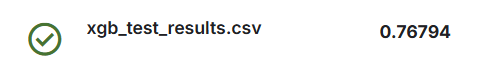

XGBClassifier performs better on cross-validation without overfitting on all train data. Kaggle test is better than Random Forest but worse than bagging.

XGBClassifier:
- F1 score on cross-validation: 0.7761184971902721
- F1 score on all train data: 0.8024132730015083

RandomForestClassifier:
- Best_params {'max_depth': 5, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 3, 'n_estimators': 100}
- F1 score on cross-validation: 0.7691404154156668
- F1 score on all train data: 0.8048780487804879

# LightGBM

We saw on xgb example that titanic dataset is small and early stopping doesn't improve time much. So let's just use grid search without early stopping

In [47]:
pipeline_lgbm_1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=0, n_jobs=-1))
])

param_grid_lgbm_1 = {
    'classifier__objective': ['binary'],
    'classifier__boosting_type': ['gbdt'],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [-1],
    'classifier__num_leaves': [30, 50],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    # 'classifier_min_split_gain': [0, 0.002, 0.01],
    'classifier__reg_lambda': [0, 0.1, 0.5],
    'classifier__subsample': [0.5, 0.8],
    'classifier__colsample_bytree': [0.7, 0.9],
    'classifier__min_child_weight': [0, 0.0005],
}

grid_search_lgbm_1 = GridSearchCV(pipeline_lgbm_1, param_grid_lgbm_1, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
grid_search_lgbm_1.fit(train_X, train_y)

print('Best_params', grid_search_lgbm_1.best_params_)
print(f'F1 score on cross-validation: {grid_search_lgbm_1.best_score_}')
print(f'F1 score on all train data: {f1_score(grid_search_lgbm_1.predict(train_X), train_y)}')

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [77]:
steps = grid_search_lgbm_1.best_estimator_.named_steps
features = steps['preprocessor'].get_feature_names_out().tolist()

data = list(zip(features, steps['classifier'].feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
df_importances


,Feature,Importance
67,remainder__Age,641
74,remainder__people_per_ticket,150
66,remainder__Pclass,94
76,remainder__family_size,67
0,one_hot__Sex_female,43
...,...,...
39,one_hot__ticket_prefix_SC/AH,0
40,one_hot__ticket_prefix_SC/AH Basle,0
6,one_hot__title_Col,0
42,one_hot__ticket_prefix_SC/Paris,0


In [78]:
lgbm_test_results = test_X.copy()
lgbm_test_results['Survived'] = grid_search_lgbm_1.best_estimator_.predict(test_X)
lgbm_test_results['Survived'].to_csv('lgbm_test_results.csv', index=True)

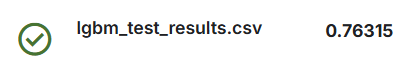